In [1]:
import sys  
sys.path.insert(0, '../src/')

from plotting import plot_impedance
from metrics import show_SSIM_MSSIM, show_MSE_RMSE_MAE, soft_F_measure

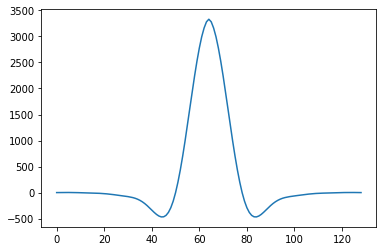

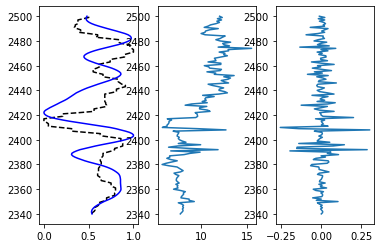

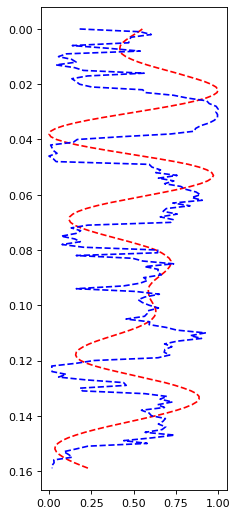

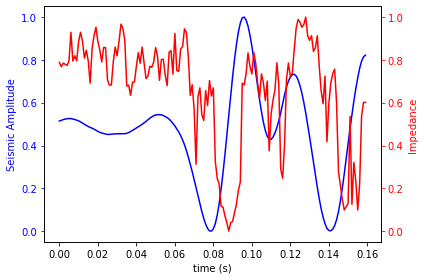

Training examples: 750
Validation examples: 275
Test examples: 275
Example shape: (160, 1)


In [2]:
%run ./01v_volve_generate_data.ipynb

import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
#import src

from skimage import feature
from skimage.filters import gaussian

import scipy.stats as stats
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# expected input data shape: (batch_size, timesteps, data_dim)

num_features = 1
num_hidden_units1 = 120

num_hidden_units2 = 150
num_responses = 1
max_epochs = 500
mini_batch_size = 5

lstm_net = keras.models.Sequential([
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units1, return_sequences=True
    ), input_shape=(160,1)),
    layers.BatchNormalization(epsilon=1e-4),
    layers.ReLU(),
    layers.Dense(150),
    layers.Dense(50),
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units2, return_sequences=True)
    ),
    layers.Dense(num_responses)
])

lstm_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 160, 240)          117120    
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 240)          960       
_________________________________________________________________
re_lu (ReLU)                 (None, 160, 240)          0         
_________________________________________________________________
dense (Dense)                (None, 160, 150)          36150     
_________________________________________________________________
dense_1 (Dense)              (None, 160, 50)           7550      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160, 300)          241200    
_________________________________________________________________
dense_2 (Dense)              (None, 160, 1)            3

In [5]:
def scheduler(epoch, lr):
    if epoch % 150 == 0 and epoch != 0:
        value = lr * tf.math.exp(-0.1)
        K.set_value(lstm_net.optimizer.lr, value)
        return K.get_value(lstm_net.optimizer.lr)
    else:
        return K.get_value(lstm_net.optimizer.lr)
    
callback =  tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                             mode='min',
                                             restore_best_weights=True,
                                             verbose=2,
                                             patience=300)
    
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=2)

loss_metrics = [
    'mse',
    'mae'
]

metric_funcs = [
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError()
]

lstm_net.compile(optimizer=optimizer,
                 loss='mse')

history_lstm = lstm_net.fit(trainX,
                            trainIp,
                            shuffle=False,
                            batch_size=mini_batch_size,
                            epochs=max_epochs,
             #               callbacks=[lr_scheduler],
                            callbacks=callback,
                            validation_data=(x_valid, y_valid),
                            validation_freq=1)

Epoch 1/500
150/150 [==============================] - 21s 41ms/step - loss: 0.1223 - val_loss: 0.1682
Epoch 2/500
150/150 [==============================] - 4s 29ms/step - loss: 0.0344 - val_loss: 0.1050
Epoch 3/500
150/150 [==============================] - 4s 29ms/step - loss: 0.0326 - val_loss: 0.0721
Epoch 4/500
150/150 [==============================] - 4s 28ms/step - loss: 0.0305 - val_loss: 0.0563
Epoch 5/500
150/150 [==============================] - 4s 28ms/step - loss: 0.0280 - val_loss: 0.0369
Epoch 6/500
150/150 [==============================] - 4s 28ms/step - loss: 0.0244 - val_loss: 0.0259
Epoch 7/500
150/150 [==============================] - 4s 28ms/step - loss: 0.0222 - val_loss: 0.0235
Epoch 8/500
150/150 [==============================] - 4s 28ms/step - loss: 0.0208 - val_loss: 0.0284
Epoch 9/500
150/150 [==============================] - 4s 28ms/step - loss: 0.0196 - val_loss: 0.0241
Epoch 10/500
150/150 [==============================] - 4s 28ms/step - loss: 0.01

9/9 [==============================] - 0s 14ms/step
(275, 160, 1)
(275, 160, 1)
(160, 275, 1)


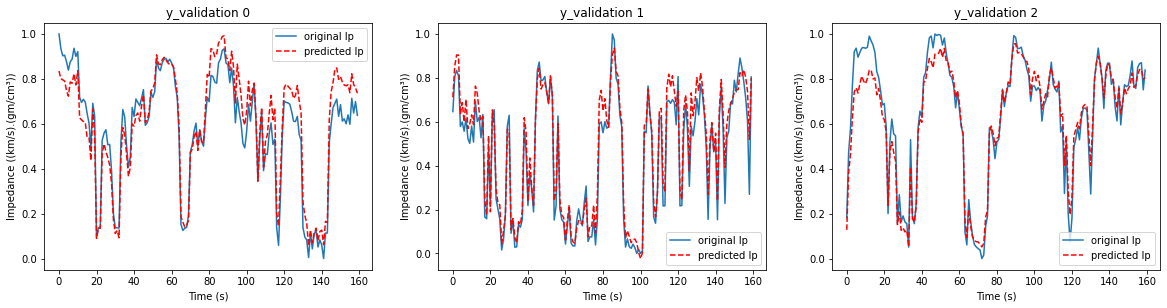

In [13]:
y_predicted = lstm_net.predict(x_test, verbose=1)

plot_impedance(n=3,
              valIp=y_test,
              X_predict=y_predicted.transpose(1,0,2))

In [14]:
(target_image, predict_image) = show_SSIM_MSSIM(y_predicted=y_predicted,
                                                y_test=y_test)

(mse_res, mae_res, m) = show_MSE_RMSE_MAE(target_image,
                                          predict_image)

print(f"MSE: ", mse_res)
print("MAE: ", mae_res)
print("RMSE: ", m.result().numpy())

Fb = soft_F_measure(target_data=target_image[:,:,0],
                    predicted_data=predict_image[:,:,0],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1)

print("Soft F Beta:", Fb)

SSIM:  0.96618336
SSIM Multiscale:  0.9789678
MSE:  0.004477973
MAE:  0.052175827
RMSE:  0.06691766
Soft F Beta: 0.6667404201794018
